In [1]:
working_on_kaggle = False

In [ ]:
repo_name = "PDLPR-algorithm"

if working_on_kaggle:
    !pip install --quiet gdown
    !apt-get install -y fonts-noto-cjk > /dev/null

    import os

    git_url = f"https://github.com/giankev/{repo_name}.git"
    os.system(f"git clone {git_url} /kaggle/working/{repo_name}")
    %cd PDLPR-algorithm/

# Import

In [ ]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

import torch
from torch.utils.data import DataLoader 
from sklearn.model_selection import train_test_split

import sys
sys.path.append('./scr/')
from pdlpr import PDLPR 
from trainer import train, set_seed, evaluate_pdlpr, infer_and_evaluate_pdlpr
from trainer import PlateDataset
from augmentation import transform_night, transform_day, transform_fn, transform_blur, transform_rot, transform_tilt_1, transform_tilt_2, transform_challenge, val_transform

from utility import char2idx, idx2char, num_classes
from utility import create_dataframe, create_cropped_dataframe, download_and_extract_dataset, plot_batch_images


# Globals

In [5]:
NUM_WORKERS = 0
SEED = 42
BATCH_SIZE = 128
TEST_BATCH_SIZE = 5
VAL_SPLIT_SIZE = 0.02
NUM_SAMPLES = 100
num_epochs = 0
lr = 1e-4  
lr_decay_factor = 0.9  
lr_decay_epochs = 20

set_seed(SEED)

save_checkpoint_path = "checkpoints/pdlpr/" # or None
name_checkpoint = "checkpoint_epoch105.pt" # None or something like "checkpoint_epoch25.pt"

if name_checkpoint is not None:
    load_checkpoint_path =  os.path.join(save_checkpoint_path, name_checkpoint) 
else:
    load_checkpoint_path = None
    
extract_path = 'dataset'
output_path = 'dataset/ccpd_subset_base.tar'
folder_path = os.path.join(extract_path, 'ccpd_subset_base', 'train')
cropped_folder = "dataset/ccpd_cropped"
font_path =  "C:/Windows/Fonts/msyh.ttc"


kaggle_working_folder = '/kaggle/working/' + repo_name
if working_on_kaggle:
    NUM_WORKERS = 2
    print("Creating ", save_checkpoint_path)
    save_checkpoint_path = os.path.join(kaggle_working_folder, save_checkpoint_path)
    os.makedirs(save_checkpoint_path, exist_ok=True)
    
    if load_checkpoint_path is not None:
        load_checkpoint_path = os.path.join(save_checkpoint_path, name_checkpoint)
        # load_checkpoint_path = "/kaggle/input/check105/checkpoint_epoch105.pt"

    
    output_path = os.path.join(kaggle_working_folder, output_path)
    extract_path = os.path.join(kaggle_working_folder, extract_path)
    folder_path = os.path.join(extract_path, 'ccpd_subset_base', 'train')
    cropped_folder = os.path.join(kaggle_working_folder, cropped_folder)
    font_path = "/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc"
    
prop = fm.FontProperties(fname=font_path)
os.makedirs(os.path.dirname(output_path), exist_ok=True)
os.makedirs(cropped_folder, exist_ok=True)


if load_checkpoint_path is not None and not os.path.isfile(load_checkpoint_path):
    raise FileNotFoundError(f"Checkpoint file not found: {load_checkpoint_path}")
    

# Dataset

## Download and extraction

In [6]:
file_id = "1RGEnfa5xWhDzO6oSoECQwQwyP4BRH5d_"
url = f'https://drive.google.com/uc?id={file_id}'

download_and_extract_dataset(url, output_path, extract_path, folder_path)

if working_on_kaggle:
    if os.path.exists(output_path):
        os.remove(output_path)

Dataset already exists, download skipped.
Dataset folder already exists, extraction skipped.


In [7]:
df = create_dataframe(folder_path, char2idx)
df = df[:NUM_SAMPLES]

df.head()

,image_path,x1_bbox,y1_bbox,x2_bbox,y2_bbox,plate_number,label
0,dataset\ccpd_subset_base\train\00227490421455-...,341,443,436,482,皖AK9954,"[52, 11, 20, 10, 10, 6, 5]"
1,dataset\ccpd_subset_base\train\00244971264367-...,413,479,530,520,皖ALX575,"[52, 11, 21, 32, 6, 8, 6]"
2,dataset\ccpd_subset_base\train\00245450191571-...,276,480,370,520,皖A65L62,"[52, 11, 7, 6, 21, 7, 3]"
3,dataset\ccpd_subset_base\train\00256944444445-...,224,566,311,607,皖A0X654,"[52, 11, 1, 32, 7, 6, 5]"
4,dataset\ccpd_subset_base\train\00257423371648-...,310,528,419,577,皖AMC629,"[52, 11, 22, 13, 7, 3, 10]"


## Crop and resize

In [8]:
# Creating a DataFrame with the cropped images
if os.path.isdir(cropped_folder):
    num_files = len([f for f in os.listdir(cropped_folder) if os.path.isfile(os.path.join(cropped_folder, f))])
    print(f"Found {num_files} files in '{cropped_folder}' (expected: {NUM_SAMPLES})")

    if num_files == NUM_SAMPLES:
        print("Cropped folder already processed. Skipping cropping step.")
    else:
        print("Cropped folder incomplete. Reprocessing...")
        cropped_df = create_cropped_dataframe(df, cropped_folder)
else:
    print(f"The folder '{cropped_folder}' doesn't exist. Creating and processing...")
    os.makedirs(cropped_folder, exist_ok=True)
    cropped_df = create_cropped_dataframe(df, cropped_folder)

Found 2000 files in 'dataset/ccpd_cropped' (expected: 100)
Cropped folder incomplete. Reprocessing...


100%|██████████| 100/100 [00:00<00:00, 184.47it/s]


## DataLoader and Augmentation

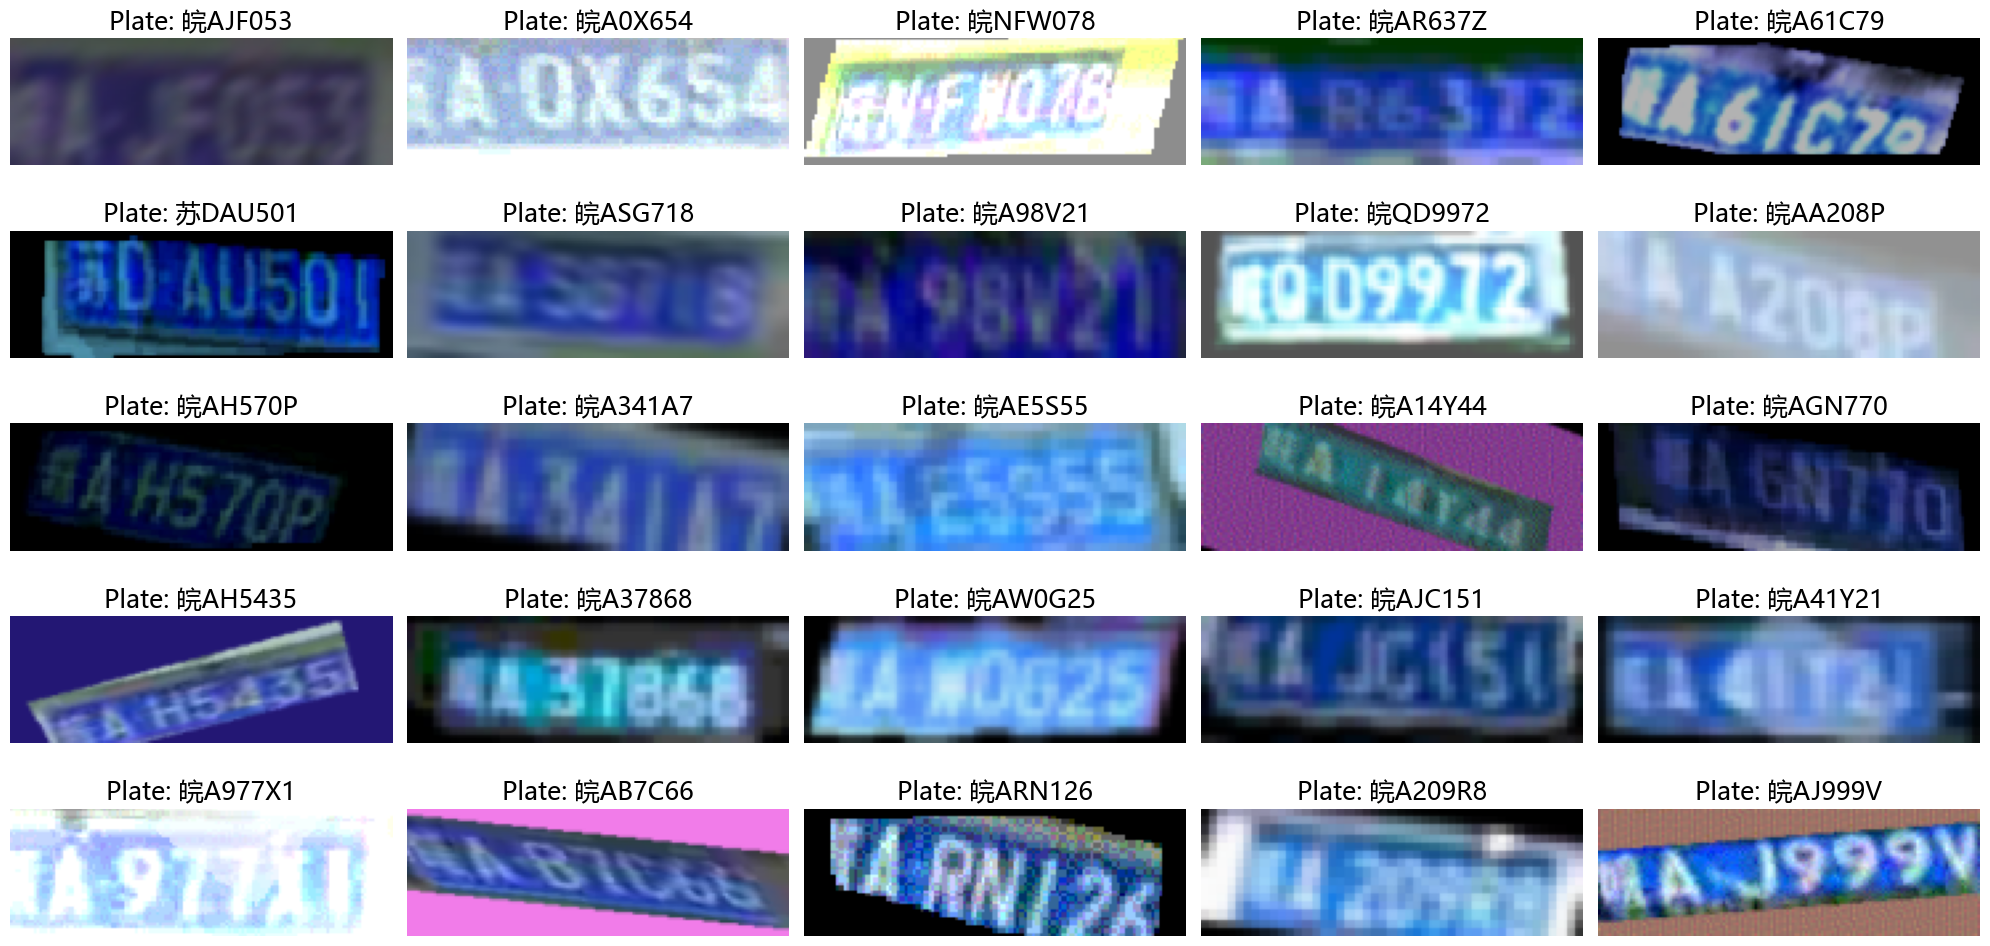

In [9]:
train_df, val_df = train_test_split(cropped_df, test_size=VAL_SPLIT_SIZE, shuffle=True, random_state=SEED)

transform_list = [
    transform_night,
    transform_day,
    transform_fn,
    transform_blur,
    transform_tilt_1,
    transform_tilt_2,
    transform_rot,
    transform_challenge
]

# 
augmented_dataset = PlateDataset(train_df, transform=transform_list)

train_loader = DataLoader(augmented_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

# Validation set 
val_dataset = PlateDataset(val_df, transform=val_transform)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

plot_batch_images(train_loader, idx2char, font=prop)

# Training

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = PDLPR(num_classes=num_classes)
model = model.to(device)  

print("Start training...")
model, train_losses, val_losses = train(train_loader, val_loader, model, char2idx, device, num_epochs,
      lr, load_checkpoint_path, save_checkpoint_path, lr_decay_factor, lr_decay_epochs)

Start training...


d:\Hard Disk\Luca\Università\Artificial Intelligence and Robotics\Computer Vision\CV project\PDLPR-algorithm\scr\trainer.py:87: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
 

Checkpoint loaded checkpoints/pdlpr/checkpoint_epoch105.pt, resuming from epoch 105
Training completed.


# Test set

In [11]:
test_output_path = 'dataset/ccpd_test.tar'
test_extract_path = 'dataset'
test_folder_path = os.path.join(test_extract_path, 'ccpd_test')
test_cropped_folder = 'dataset/ccpd_test_cropped'

# Adapt to work on kaggle
if working_on_kaggle:
    test_output_path = os.path.join(kaggle_working_folder, test_output_path)

    test_extract_path = os.path.join(kaggle_working_folder, test_extract_path)
    test_folder_path = os.path.join(test_extract_path, 'ccpd_test')
    test_cropped_folder = os.path.join(kaggle_working_folder, test_cropped_folder)

# Create folder if they don't exist
os.makedirs(os.path.dirname(test_output_path), exist_ok=True)
os.makedirs(test_cropped_folder, exist_ok=True)

# Download url for test set
file_id_test = "1rlOc7X2_C9vq2sm1ULBjNAgb_gy6CP8R" # Mattia
# file_id_test = '1PnYtN0P6m36LmjztvhVmVLqZwZAp9Q3X'# Kevin
# file_id_test = "1n1RAP_4MSPUw6hOASU48NHIzVFfRdII5"  5K samples

url_test = f'https://drive.google.com/uc?id={file_id_test}'
download_and_extract_dataset(url_test, test_output_path, test_extract_path, test_folder_path)

if os.path.exists(test_folder_path):
    subfolders = [name for name in os.listdir(test_folder_path)
                  if os.path.isdir(os.path.join(test_folder_path, name))]
    subfolders = sorted(subfolders)
    print(f"Subfolders in '{test_folder_path}':")
else:
    print(f"The folder '{test_folder_path}' does not exist.")

for subfolder in subfolders:
    print(f"\nEvaluation on CCPD_{subfolder}")
    subfolder_path = os.path.join(test_folder_path, subfolder) 
    
    sub_df = create_dataframe(subfolder_path, char2idx)

    cropped_subfolder =  os.path.join(test_cropped_folder, subfolder)
    os.makedirs(cropped_subfolder, exist_ok=True)
    cropped_sub_df = create_cropped_dataframe(sub_df, cropped_subfolder)

    test_dataset = PlateDataset(cropped_sub_df, transform=val_transform)
    test_loader = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
    
    test_loss, test_char_acc, test_seq_acc, avg_fps = evaluate_pdlpr(model, test_loader, char2idx, "cuda")

Dataset already exists, download skipped.
Dataset folder already exists, extraction skipped.
Subfolders in 'dataset\ccpd_test':

Evaluation on CCPD_base
Evaluation | Loss: 0.0031 | Char Acc: 0.9997 | Seq Acc: 0.9980 | FPS: 93.57

Evaluation on CCPD_blur
Evaluation | Loss: 0.0569 | Char Acc: 0.9820 | Seq Acc: 0.9030 | FPS: 105.08

Evaluation on CCPD_challenge
Evaluation | Loss: 0.0773 | Char Acc: 0.9806 | Seq Acc: 0.8940 | FPS: 102.81

Evaluation on CCPD_db
Evaluation | Loss: 0.1332 | Char Acc: 0.9709 | Seq Acc: 0.8480 | FPS: 93.49

Evaluation on CCPD_fn
Evaluation | Loss: 0.1391 | Char Acc: 0.9800 | Seq Acc: 0.9020 | FPS: 91.63

Evaluation on CCPD_rotate
Evaluation | Loss: 0.0840 | Char Acc: 0.9887 | Seq Acc: 0.9410 | FPS: 91.88

Evaluation on CCPD_tilt
Evaluation | Loss: 0.1013 | Char Acc: 0.9773 | Seq Acc: 0.8680 | FPS: 91.67

Evaluation on CCPD_weather
Evaluation | Loss: 0.0094 | Char Acc: 0.9983 | Seq Acc: 0.9880 | FPS: 86.60


# Evaluation on specific dataset

In [12]:
for subfolder in subfolders:
    if subfolder == "tilt":
        print(f"\nEvaluation on CCPD_{subfolder}")
        subfolder_path = os.path.join(test_folder_path, subfolder) 
        
        sub_df = create_dataframe(subfolder_path, char2idx)
    
        cropped_subfolder =  os.path.join(test_cropped_folder, subfolder)
        os.makedirs(cropped_subfolder, exist_ok=True)
        cropped_sub_df = create_cropped_dataframe(sub_df, cropped_subfolder)
    
        test_dataset = PlateDataset(cropped_sub_df, transform=val_transform)
        test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=NUM_WORKERS)
        
        test_loss, test_char_acc, test_seq_acc, fps = evaluate_pdlpr(model, test_loader, char2idx, "cuda")


Evaluation on CCPD_tilt
Evaluation | Loss: 0.1002 | Char Acc: 0.9773 | Seq Acc: 0.8680 | FPS: 101.39


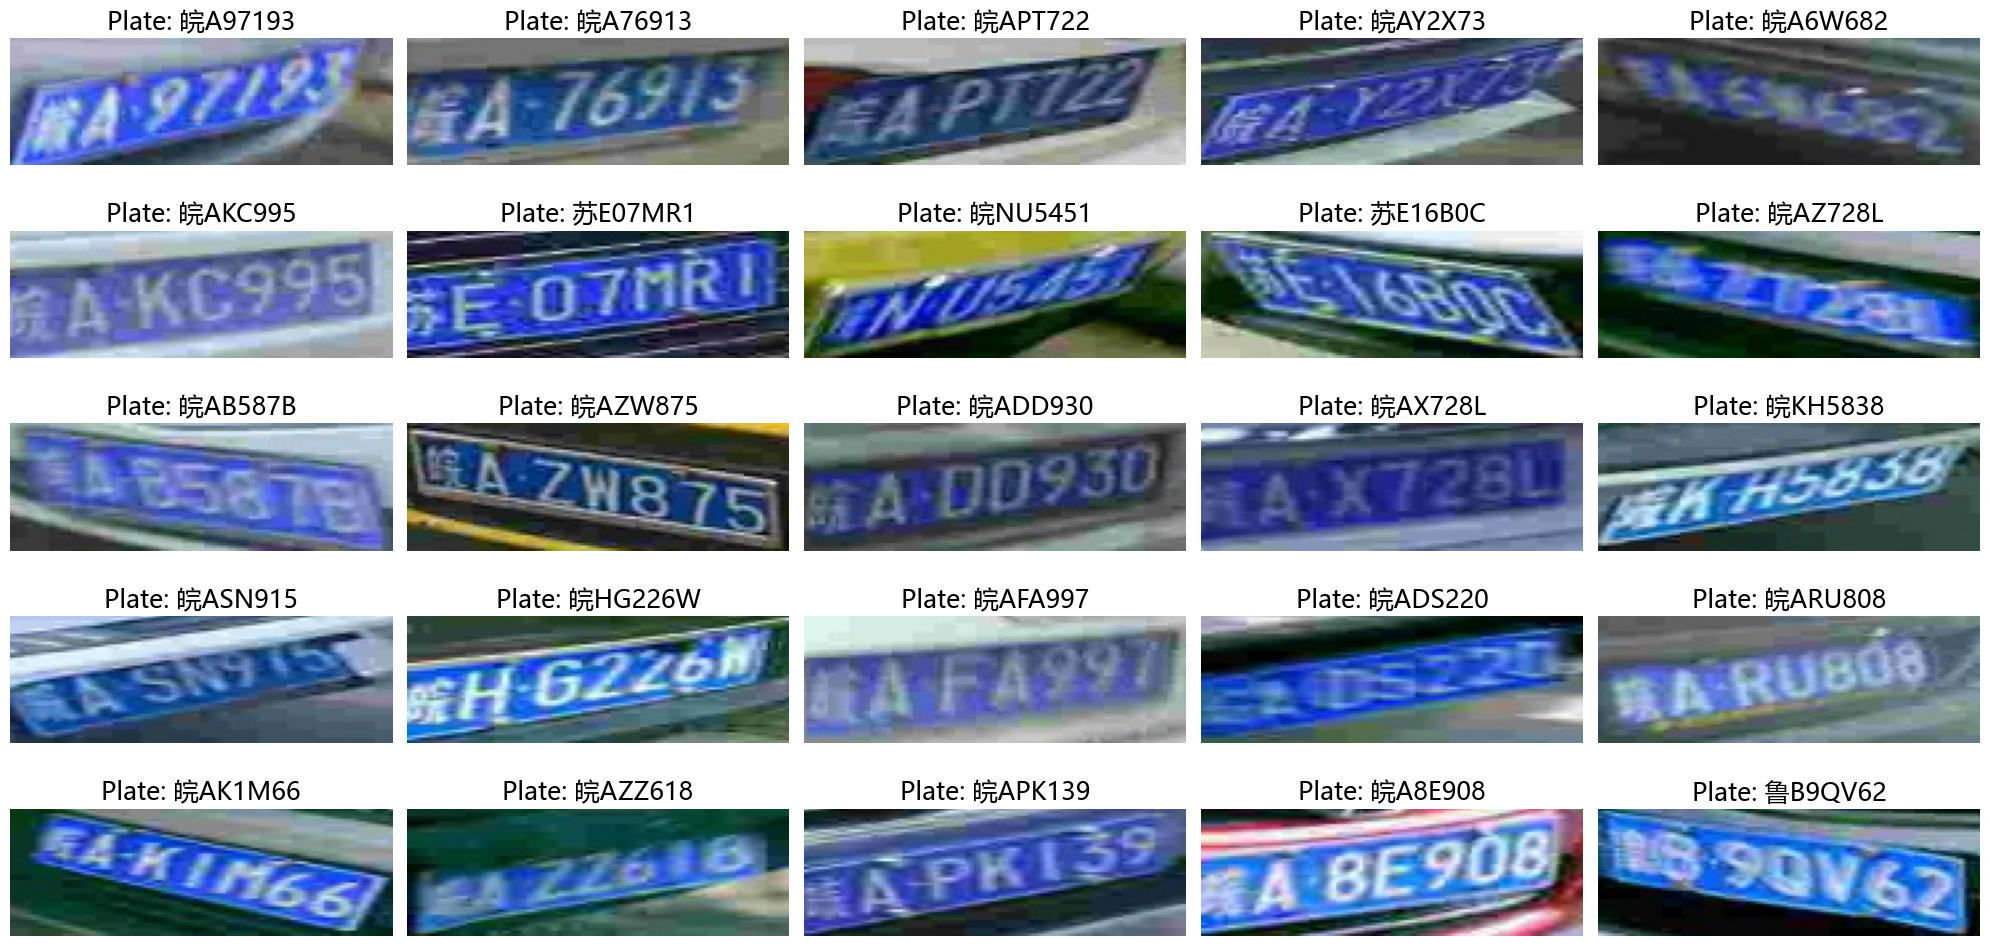

In [13]:
plot_batch_images(test_loader, idx2char, prop)

5


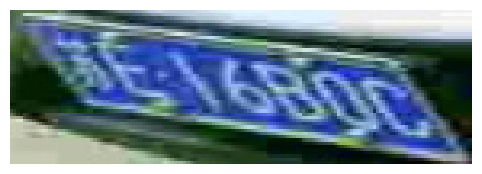

Raw sequence (argmax per timestep): 苏E-1-----6---B-0-C
Predetta:          苏E16B0C
Target:            苏E16B0C
CTC Loss:          0.0002
Len pred:          7, Len true: 7
Character Accuracy: 1.0000
Sequence Accuracy:  1


In [14]:
images, labels = next(iter(test_loader))
i = np.random.randint(0, len(images))
print(i)

# Estrai immagine e label
first_image = images[i]
first_label = labels[i]

# Mostra l'immagine
plt.figure(figsize=(10, 2))
# Se l'immagine ha una sola canale (grayscale), squeeze per renderla 2D
if first_image.shape[0] == 1:
    plt.imshow(first_image.squeeze(0).cpu().numpy(), cmap='gray')
else:
    plt.imshow(np.transpose(first_image.cpu().numpy(), (1, 2, 0)))  # per RGB
plt.axis('off')
plt.show()

decoded_str, loss_value = infer_and_evaluate_pdlpr(model, first_image, first_label, char2idx, idx2char)